<a href="https://colab.research.google.com/github/Joab-S/SimulacaoEstocasticaUFC/blob/main/SistemaDeSeguros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import simpy as sp
import numpy as np
import matplotlib.pyplot as mp

In [102]:
# Variáveis de Sistema:
N, C = 10, 1000
client_number = N
capital = C
last_event_time = 0
minCap = capital

# Parâmetros do Sistema:
arrival_fee = 1/4                   # Em média, chegam 4 pessoas por mês
exit_fee = 12         # Em média, um cliente permanece no seguro por 12 meses
occurrence_fee = 3    # Em média, um cliente aciona o seguro a cada 3 meses
monthly_payment = 42
occurrence_value = 100
occurrence_variance = 40
limit = 60                       # Limite de simulação para 12 meses

In [44]:
def initVarSystem(N, C):
  global client_number
  global capital
  global minCap
  global last_event_time
   
  client_number = N
  capital = C
  minCap = capital
  last_event_time = 0

In [80]:
def partialMonthlyPayment(env, n):
  global capital
  global last_event_time

  value = capital + (n * (env.now - last_event_time) * monthly_payment)
  #print("Mensalidade paga, Capital =", value)
  last_event_time = env.now

  return value

In [81]:
def arrivalSystem(env):
  global client_number
  global last_event_time
  global capital
  
  while True:
    
    yield env.timeout(np.random.exponential(arrival_fee))
    #print("Um novo cliente chegou. n: ", client_number)
    capital = partialMonthlyPayment(env, client_number)
    client_number += 1
    if(client_number == 1):
      env.process(occurrence(env))
      env.process(exitSystem(env))

In [79]:
def exitSystem(env):
  global client_number
  global last_event_time
  global capital

  while (client_number > 0):
    yield env.timeout(np.random.exponential(exit_fee/client_number))
    #print("Um cliente deixou o sistema. n:", client_number)
    capital = partialMonthlyPayment(env, client_number)
    client_number -= 1
  

In [78]:
def occurrence(env):
  global client_number
  global minCap
  global last_event_time
  global capital
  global minCap

  while (client_number > 0):
    yield env.timeout(np.random.exponential(occurrence_fee/client_number))

    custo = np.random.normal(occurrence_value, occurrence_variance)
    capital = capital - custo
    #print("Uma ocorrência foi registrada. Custo:", custo, "- Capital: ", capital)
    minCap = min(minCap, capital)

    

In [76]:
def initSystem(env):
  global N
  global C
  global client_number
  
  initVarSystem(N, C)
  env.process(arrivalSystem(env))
  if (client_number > 0):
    env.process(occurrence(env))
    env.process(exitSystem(env))

In [83]:
def minCapitalSystem():
  global minCap
  env = sp.Environment()
  initSystem(env)
  env.run(until=limit)
  #print("Fim da execução!")

  return minCap

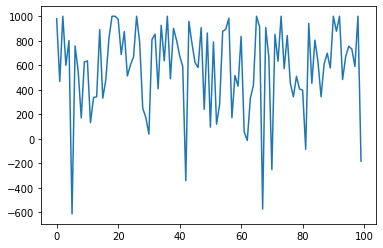

In [105]:
min_values = []
for i in range(100):
  min_values.append(minCapitalSystem())


mp.plot(min_values)


In [106]:
print(np.mean(min_values))
print(np.std(min_values))

from scipy.stats import norm

prob = norm.cdf(-np.mean(min_values)/np.std(min_values))
print(prob)

579.4539013961329
356.7459704052896
0.05215846341868452
